In [7]:
import pygplates
import points_in_polygons
import numpy as np
import pandas as pd
import pickle
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from create_gpml import create_gpml_regular_long_lat_mesh
from skimage import measure
%matplotlib inline

In [3]:
def run_grid_pip(time,points,polygons,rotation_model):
    
    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)
    
    rpolygons = []
    for polygon in reconstructed_polygons:
        #print polygon.get_description()
        #if polygon.get_reconstructed_geometry() == 'PolygonOnSphere':
        if polygon.get_reconstructed_geometry():
            #pri#nt polygon.get_reconstructed_geometry()
            rpolygons.append(polygon.get_reconstructed_geometry())


    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)
            
    bi = np.array(zval).reshape(181,361)
    
    return bi

In [4]:
 def lamo(bi):
    #
    #so this sucks
    #essentialy at time slices where the supercontinent polygon covers all of one
    #side of our array, python can't tell which is in and which is out
    #so we arbitarilly buffer the size of our arrays below to make them one entry bigger
    #so we can get what we need, then we undo it later
    #

    #pad
    pad_hor = np.zeros((1,361))
    pad_ver = np.zeros((182,1))
    pad1 = np.vstack((bi,pad_hor))
    pad2 = np.hstack((pad_ver,pad1))
    pad3 = np.hstack((pad2,pad_ver))
    contours = measure.find_contours(pad3,0.1, fully_connected='low')
    contour_polygons = []
    for n,cp in enumerate(contours):
        cp[:,1] = cp[:,1]-1
        cp[:,0] = cp[:,0]-1

        cp[np.where(cp[:,0]<0.),0] = 0
        cp[np.where(cp[:,0]>180.),0] = 180
        cp[np.where(cp[:,1]<0.),1] = 0
        cp[np.where(cp[:,1]>360.),1] = 360
        cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
        contour_polygons.append(cpf)
    
    return contour_polygons

In [10]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_GPC/Sample_data/'

#Matthews et al. (2016)
Mat16_rotation_model = pygplates.RotationModel('%sMat16_410-0Ma.rot' % basedir)
Mat16_polygons = pygplates.FeatureCollection('%sMat16_PresentDay_ContinentalPolygons.gpml' % basedir)
Mat16_topologies = ['%sMat16_Mesozoic-Cenozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_Paleozoic_plate_boundaries.gpml' % basedir,
                           '%sMat16_TopologyBuildingBlocks.gpml' % basedir]
Mat16_COBs = pygplates.FeatureCollection('%sMat16_COBs.gpml' % basedir)

#Domeier models
Dom18_rotation_model = pygplates.RotationModel('%sDom18_merge-Rotation_ASM.rot' % basedir)
Dom18_polygons = pygplates.FeatureCollection('%sDom18_merge-Land_ASM.gpml' % basedir)
Dom18_topologies = ['%sDom18_merge-Ridges_ASM.gpml' % basedir,
                  '%sDom18_merge-Topologies_ASM.gpml' % basedir,
                  '%sDom18_merge-Transforms_ASM.gpml' % basedir,
                  '%sDom18_merge-Trenches_ASM.gpml' % basedir,
                  '%sDom18_merge-ArbitaryLines_ASM.gpml' % basedir]
Dom_COBs = pygplates.FeatureCollection('%sDom18_merge-COBs.gpml' % basedir)

#Merdith model
Mer17_rotation_model = pygplates.RotationModel('%sMer17_rotations.rot' % basedir)
Mer17_polygons = pygplates.FeatureCollection('%sMer17_polygons.gpml' % basedir)
Mer17_topologies = ['%sMer17_Transforms.gpml' % basedir,
                  '%sMer17_Topologies.gpml' % basedir,
                  '%sMer17_Divergence.gpml' % basedir,
                  '%sMer17_Convergence.gpml' % basedir]
Mer17_COBs = pygplates.FeatureCollection('%sMer17_COBs.gpml' % basedir)

#load rift files, we want the ones labelled 'plotting' because they have the correct plate IDs
Mer19_rifts = pygplates.FeatureCollection('%sMer19_Neoproterozoic_rifts_for_plotting.gpml' % basedir)
Dom18_rifts = pygplates.FeatureCollection('%sDom18_Palaeozoic_rifts_for_plotting.gpml' % basedir)
phanerozoic_rifts =pygplates.FeatureCollection('%sSengor-Natalin-rifts.gpml' % basedir)

multipoints = create_gpml_regular_long_lat_mesh(1)

for multipoint in multipoints:
    for mp in multipoint.get_all_geometries():
        points = mp.to_lat_lon_point_list()

In [12]:
#this confirms that all features within our COB terranes are actually polygons and not multipoints in disguise
polygons = []
for feature in Mat16_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mat16_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Dom_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Dom18_COBs = pygplates.FeatureCollection(polygons)

polygons = []
for feature in Mer17_COBs:
    for geom in feature.get_geometries():
        polygon = []
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

Mer17_COBs = pygplates.FeatureCollection(polygons)

0
200
400
600
800
1000


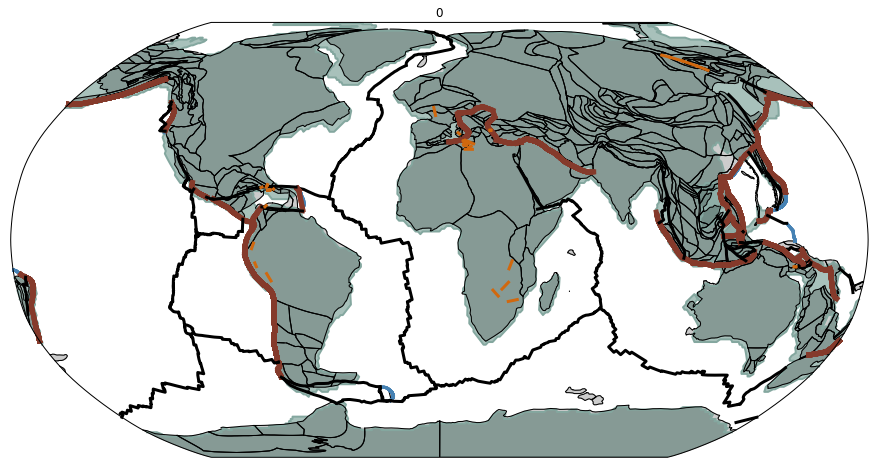

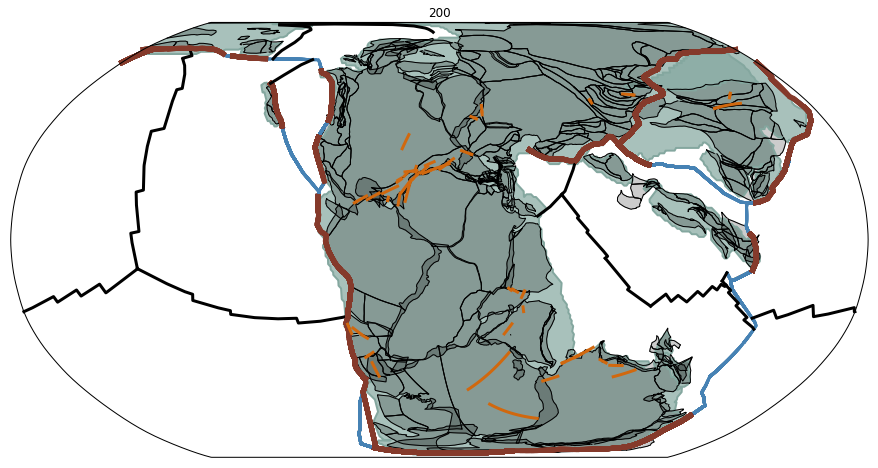

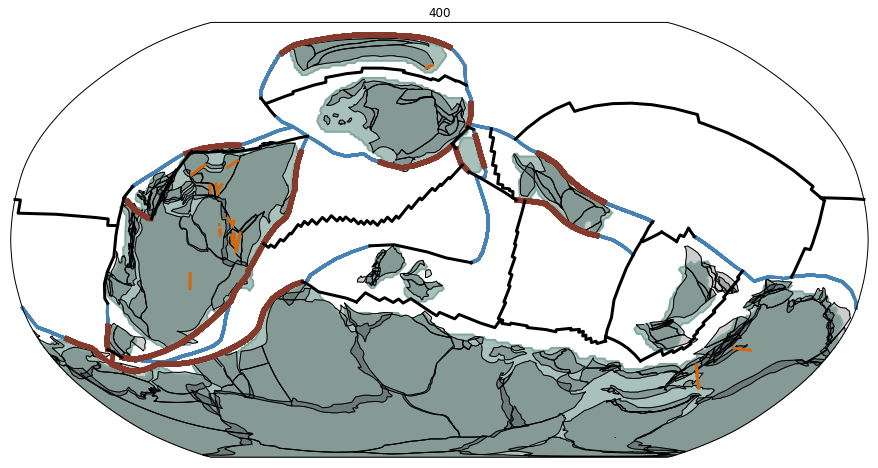

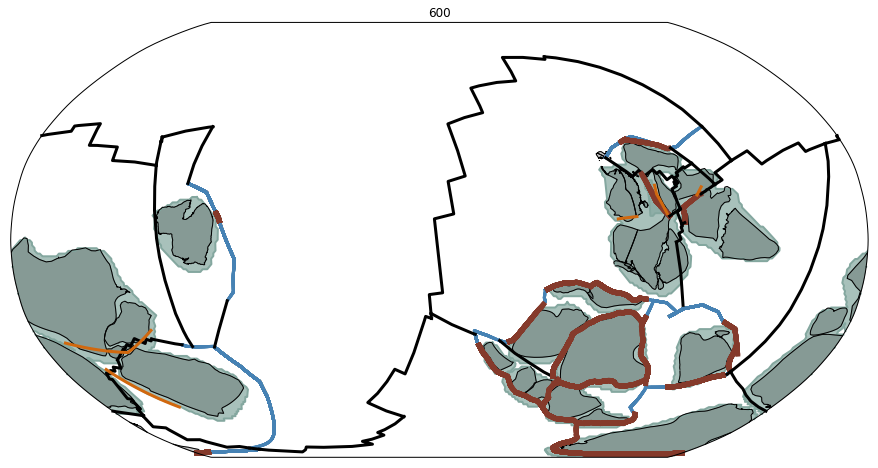

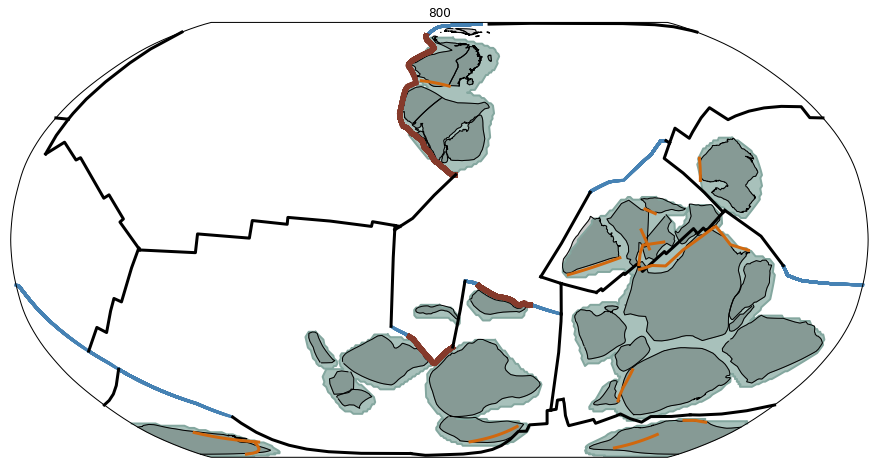

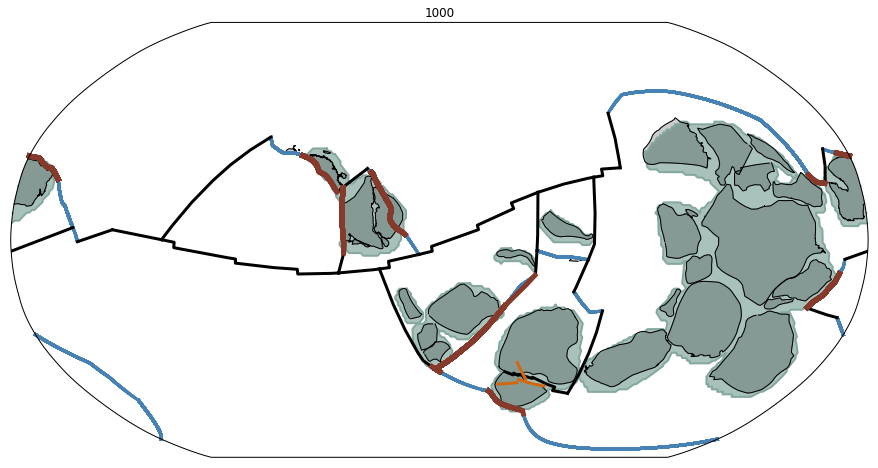

In [22]:
date_line_wrapper = pygplates.DateLineWrapper(0)
times = np.arange(0,1200,200)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
projection = ccrs.Robinson()

for i,time in enumerate(times):
    print time
      
    if time <= 410:
        COBs = Mat16_COBs
        rotations = Mat16_rotation_model
        topologies = Mat16_topologies
        polygons = Mat16_polygons
        rifts = phanerozoic_rifts
    elif time > 410 and time <= 500:
        COBs = Dom18_COBs
        rotations = Dom18_rotation_model
        topologies = Dom18_topologies
        polygons = Dom18_polygons
        if time <= 450:
            rifts =phanerozoic_rifts
        else:
            rifts = Dom18_rifts
    else:
        COBs = Mer17_COBs
        rotations = Mer17_rotation_model
        topologies = Mer17_topologies
        polygons = Mer17_polygons
        rifts = Mer19_rifts
        
    contour_polygons = []

    bi = run_grid_pip(time,points,COBs,rotations)

    contour_polygons = lamo(bi)
    
    #ergh
    resolved_topologies = []
    shared_boundary_sections = []
    all_tesselated_shared_sub_segment = []
    reconstructed_COBs = []
    reconstructed_rifts = []
    reconstructed_cratons = []
    
    pygplates.resolve_topologies(topologies,rotations, resolved_topologies, time, shared_boundary_sections)
    pygplates.reconstruct(COBs, rotations, reconstructed_COBs, time)
    pygplates.reconstruct(rifts, rotations, reconstructed_rifts, time)
    pygplates.reconstruct(polygons, rotations, reconstructed_cratons, time)

    #initiate figure 
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,8), subplot_kw={'projection': projection})
    ax.set_global()
    
    area_threshold = 500000

    for pg in contour_polygons:
        if pg.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
            wrapped_polygons_lat = []
            wrapped_polygons_lon = []
            wrapped_polygons = date_line_wrapper.wrap(pg, 1)
            for wrapped_polygon in wrapped_polygons:
                for wrapped_point in wrapped_polygon.get_exterior_points():
                    wrapped_point_lat_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
                    wrapped_polygons_lat.append(wrapped_point.get_latitude())
                    wrapped_polygons_lon.append(wrapped_point.get_longitude())
                     
            ax.plot(wrapped_polygons_lon, wrapped_polygons_lat, '#84a79f', linewidth=2, zorder=0, transform=poly_data_crs)
            ax.fill(wrapped_polygons_lon, wrapped_polygons_lat, '#84a79f', fill=True, alpha=0.7, zorder=0, transform=poly_data_crs)
            
    for crat in reconstructed_cratons:
        crat_geom = pygplates.PolygonOnSphere(crat.get_reconstructed_geometry())
        wrapped_cratons = date_line_wrapper.wrap(crat_geom, 1)
        for wrapped_craton in wrapped_cratons:
            wrapped_cratons_lat = []
            wrapped_cratons_lon = []
            for wrapped_craton_point in wrapped_craton.get_exterior_points():
                wrapped_craton_lat_lon = wrapped_craton_point.get_latitude(), wrapped_craton_point.get_longitude()
                wrapped_cratons_lat.append(wrapped_craton_point.get_latitude())
                wrapped_cratons_lon.append(wrapped_craton_point.get_longitude())

            ax.plot(wrapped_cratons_lon, wrapped_cratons_lat, color='k', linewidth=1 ,zorder=0, transform=poly_data_crs)
            ax.fill(wrapped_cratons_lon, wrapped_cratons_lat, color='k', fill=True, alpha=0.2, zorder=0, transform=poly_data_crs)

    
    #Proximity Test and plate boundaries
    distance_kms = 150
    distance_threshold_radians = distance_kms/pygplates.Earth.mean_radius_in_kms
    
    for shared_boundary_section in shared_boundary_sections:
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
           
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    mor_wrapped_point_lat = []
                    mor_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                        mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k', linewidth=3, zorder=2, transform=data_crs)

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_transform:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
        
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    trans_wrapped_point_lat = []
                    trans_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        trans_wrapped_point_lat.append(wrapped_point.get_latitude())
                        trans_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(trans_wrapped_point_lon,trans_wrapped_point_lat, color='k', linewidth=3, zorder=2, transform=data_crs)

        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_unclassified_feature:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
        
                wrapped_polylines = date_line_wrapper.wrap(tmp)
                for wrapped_polyline in wrapped_polylines:
                    arb_line_wrapped_point_lat = []
                    arb_line_wrapped_point_lon = []
                    for wrapped_point in wrapped_polyline.get_points():
                        arb_line_wrapped_point_lat.append(wrapped_point.get_latitude())
                        arb_line_wrapped_point_lon.append(wrapped_point.get_longitude())
                    ax.plot(arb_line_wrapped_point_lon,arb_line_wrapped_point_lat, color='k', linewidth=3, zorder=2, transform=data_crs)
                        
        if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
            for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
                tmp = shared_sub_segment.get_resolved_geometry()
                tesselated_shared_sub_segment = tmp.to_tessellated(np.radians(0.5))      

                all_tesselated_shared_sub_segment.append(tesselated_shared_sub_segment)
                
                cont_sz_lons = []
                cont_sz_lats = []
                ocean_sz_lons = []
                ocean_sz_lats = []
                
                for segment in tesselated_shared_sub_segment.get_segments():

                    for pg2 in contour_polygons:

                        if pg2.get_area()*pygplates.Earth.mean_radius_in_kms**2 > area_threshold:
                    
                            pg3 = pg2
                        
                            distance_radians = pygplates.GeometryOnSphere.distance(segment.get_arc_point(0.5), 
                                                                                   pg3,
                                                                                   distance_threshold_radians,
                                                                                   geometry2_is_solid=True)
                           
                            if distance_radians is not None:

                                cont_sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                cont_sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
                                
                            if distance_radians is None:
                                ocean_sz_lons.append(segment.get_arc_point(0.5).to_lat_lon()[1])
                                ocean_sz_lats.append(segment.get_arc_point(0.5).to_lat_lon()[0])
                                #break
            
                    i = zip(cont_sz_lats, cont_sz_lons)
                    #print i
                    if len(i) > 2:
                        polyline = pygplates.PolylineOnSphere(i)
                        wrapped_polylines = date_line_wrapper.wrap(polyline)
                        for wrapped_polyline in wrapped_polylines:
                            cont_sub_point_lat = []
                            cont_sub_point_lon = []
                            for wrapped_point in wrapped_polyline.get_points():
                                cont_sub_point_lat.append(wrapped_point.get_latitude())
                                cont_sub_point_lon.append(wrapped_point.get_longitude())
                            ax.plot(cont_sub_point_lon,cont_sub_point_lat, color='#853a2b', linewidth=5, zorder=2, transform=data_crs)  

                    j = zip(ocean_sz_lats, ocean_sz_lons)
                    if len(j) > 2:
                        polyline1 = pygplates.PolylineOnSphere(j)
                        wrapped_polylines1 = date_line_wrapper.wrap(polyline1)
                        for wrapped_polyline1 in wrapped_polylines1:
                            oceanic_sub_point_lat = []
                            oceanic_sub_point_lon = []
                            for wrapped_point1 in wrapped_polyline1.get_points():
                                oceanic_sub_point_lat.append(wrapped_point1.get_latitude())
                                oceanic_sub_point_lon.append(wrapped_point1.get_longitude())
                            ax.plot(oceanic_sub_point_lon,oceanic_sub_point_lat, color='#4682b4', linewidth=3, zorder=1, transform=data_crs)            
#
                
    for rift in reconstructed_rifts:
        if (rift.get_feature().get_valid_time()[0] >= time) and (time >= int(rift.get_feature().get_valid_time()[1]) ):
            rift_polyline = rift.get_reconstructed_geometry()
            wrapped_and_tessellated_polylines = date_line_wrapper.wrap(rift_polyline, 1)

            rift_lats = []
            rift_lons = [] 
            for wrapped_polyline in wrapped_and_tessellated_polylines:
                for wrapped_point in wrapped_polyline.get_points():

                    rift_lons.append(wrapped_point.get_longitude())
                    rift_lats.append(wrapped_point.get_latitude())
            ax.plot(rift_lons,rift_lats,color='#d1680e', linewidth=3, transform=data_crs)

            
    ax.set_title(time)
